## Importacion de los modulos necesarios

In [1]:
# Procesamiento de datos
import numpy as np
import pandas as pd
from sklearn import utils
from sklearn import preprocessing as prp
import shap
import optuna

# Modelos
import tensorflow as tf
from tensorflow import keras
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping

# Graficadores
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

#Otros
# !pip install category_encoders
from category_encoders import TargetEncoder
# !pip install scikeras
from scikeras.wrappers import KerasClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Cargar y modificar los nombres de las columnas del dataset

In [2]:
dataset = pd.read_excel("DF_D.xlsx")
names = ['label','edad','genero','ANB','ICS/SN','IMPA','ICI/PLANO','interincisal','lab sup/lin E','lab inf/lin E','nasolabial','Overjet','Oberbite','j-s','Angulo','Discrepancia','Clase','Perfil']
df = pd.DataFrame(dataset)
df = df.drop(['No.'],axis=1)
df = df.drop(0,axis=0)
df.columns = names
df.shape

(342, 18)

### Se extrae un valor que funje como outlayer

In [3]:
# Se elimina la columna con el outlayer de 932
df = df.drop(df[df['j-s']==931].index[0],axis=0)

## Se ve la integridad y naturaleza estadistica de los datos

In [4]:
df.nunique()
# 4 generos?

label             2
edad             32
genero            4
ANB              24
ICS/SN           39
IMPA             42
ICI/PLANO        39
interincisal     53
lab sup/lin E    24
lab inf/lin E    27
nasolabial       55
Overjet          27
Oberbite         24
j-s              32
Angulo           31
Discrepancia      5
Clase             3
Perfil            5
dtype: int64

In [5]:
print(df.genero.unique())
df.genero = df.genero.replace({'f ':'F'})
df.genero = df.genero.replace({'f':'F'})
print(df.genero.unique())

['M' 'F' 'f ' 'f']
['M' 'F']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341 entries, 1 to 342
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          341 non-null    float64
 1   edad           341 non-null    float64
 2   genero         341 non-null    object 
 3   ANB            341 non-null    float64
 4   ICS/SN         341 non-null    float64
 5   IMPA           341 non-null    float64
 6   ICI/PLANO      341 non-null    float64
 7   interincisal   341 non-null    float64
 8   lab sup/lin E  341 non-null    float64
 9   lab inf/lin E  341 non-null    float64
 10  nasolabial     341 non-null    float64
 11  Overjet        341 non-null    float64
 12  Oberbite       341 non-null    float64
 13  j-s            341 non-null    float64
 14  Angulo         341 non-null    float64
 15  Discrepancia   341 non-null    float64
 16  Clase          341 non-null    float64
 17  Perfil         341 non-null    float64
dtypes: float64(17),

## Se mezclan las columnas del dataframe

In [7]:
df = utils.shuffle(df,random_state=1)
x_train, x_test, y_train, y_test = train_test_split(df.drop(['label'],axis=1),df['label'],test_size=0.2,random_state=42)
x_train.shape,x_test.shape

((272, 17), (69, 17))

## Realizacion de la codificacion de variables categoricas

In [8]:
# Training
encoder = TargetEncoder(cols=['genero','Clase'])
encoder.fit(x_train,y_train)
#Utiliza el mismo encoder para transformar el dataset de testing y el de testing?
df_train_enc = encoder.transform(x_train)
df_test_enc = encoder.transform(x_test)
print(df_train_enc.info())
df_train_enc.head()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 172 to 79
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   edad           272 non-null    float64
 1   genero         272 non-null    float64
 2   ANB            272 non-null    float64
 3   ICS/SN         272 non-null    float64
 4   IMPA           272 non-null    float64
 5   ICI/PLANO      272 non-null    float64
 6   interincisal   272 non-null    float64
 7   lab sup/lin E  272 non-null    float64
 8   lab inf/lin E  272 non-null    float64
 9   nasolabial     272 non-null    float64
 10  Overjet        272 non-null    float64
 11  Oberbite       272 non-null    float64
 12  j-s            272 non-null    float64
 13  Angulo         272 non-null    float64
 14  Discrepancia   272 non-null    float64
 15  Clase          272 non-null    float64
 16  Perfil         272 non-null    float64
dtypes: float64(17)
memory usage: 38.2 KB
None


,edad,genero,ANB,ICS/SN,IMPA,ICI/PLANO,interincisal,lab sup/lin E,lab inf/lin E,nasolabial,Overjet,Oberbite,j-s,Angulo,Discrepancia,Clase,Perfil
172,15.0,0.489150,3.0,102.0,75.0,91.0,125.0,0.0,1.0,72.0,2.0,2.0,398.0,172.0,4.0,0.718648,2.0
148,29.0,0.489150,3.5,106.0,66.0,106.0,110.0,-2.0,0.0,65.0,3.0,2.5,400.0,169.0,2.0,0.386076,1.0
209,12.0,0.527778,8.0,119.0,51.0,92.0,105.0,3.5,3.0,96.0,10.0,5.0,401.0,159.0,3.0,0.718648,3.0
179,16.0,0.527778,3.0,110.0,62.0,100.0,108.0,0.0,1.0,88.0,5.0,3.5,402.0,165.0,4.0,0.386076,2.0
282,21.0,0.527778,7.0,100.0,73.0,100.0,120.0,0.0,0.0,113.0,1.5,1.0,394.0,163.0,3.0,0.386076,1.0


In [9]:
# # Testing
# encoder = TargetEncoder(cols=['genero','Clase'])
# encoder.fit(x_test,y_test)
# df_test_enc = encoder.transform(x_test,y_test)
# # df_test_enc = df_test_enc.astype(float)
# print(df_test_enc.info())
# df_test_enc.head()

## EDA mediante diagramas de violin

In [ ]:
plt.figure(figsize=(20,30))
i = 1
for column in df_train_enc:
  plt.subplot(6,3,i)
  plt.violinplot(dataset=df_train_enc[column],vert=False)
  plt.title(column)
  i+=1

In [ ]:
df_train_enc['ICI/PLANO'].unique()
#Valores atipicos de bajo valor

## Estandarizacion

In [10]:
# Train
# transform = prp.MinMaxScaler()#82
# transform = prp.RobustScaler()
# transform = prp.StandardScaler()
transform = prp.QuantileTransformer(output_distribution='uniform')
colums = transform.fit_transform(df_train_enc)
df_train_enc_est = pd.DataFrame(colums)
df_train_enc_est.columns = df_train_enc.columns
df_train_enc_est

n_quantiles (1000) is greater than the total number of samples (272). n_quantiles is set to n_samples.


,edad,genero,ANB,ICS/SN,IMPA,ICI/PLANO,interincisal,lab sup/lin E,lab inf/lin E,nasolabial,Overjet,Oberbite,j-s,Angulo,Discrepancia,Clase,Perfil
0,0.455720,0.0,0.265683,0.204797,0.933579,0.191882,0.756458,0.630996,0.568266,0.014760,0.214022,0.370849,0.603321,0.885609,1.000000,1.0,0.608856
1,0.933579,0.0,0.341328,0.418819,0.595941,0.894834,0.191882,0.267528,0.369004,0.000000,0.442804,0.518450,0.726937,0.769373,0.256458,0.0,0.238007
2,0.138376,1.0,0.896679,0.931734,0.036900,0.238007,0.079336,0.961255,0.835793,0.459410,0.977860,0.928044,0.787823,0.118081,0.494465,1.0,0.857934
3,0.584871,1.0,0.265683,0.660517,0.381919,0.612546,0.142066,0.630996,0.568266,0.169742,0.824723,0.800738,0.832103,0.464945,1.000000,0.0,0.608856
4,0.852399,1.0,0.821033,0.118081,0.900369,0.612546,0.586716,0.630996,0.369004,0.939114,0.132841,0.160517,0.352399,0.333948,0.494465,0.0,0.238007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,0.044280,0.0,0.896679,0.948339,0.059041,0.385609,0.079336,0.630996,0.730627,0.208487,0.985240,0.845018,0.726937,0.267528,1.000000,1.0,0.608856
268,0.254613,0.0,0.418819,0.714022,0.479705,0.817343,0.359779,0.885609,0.568266,0.734317,0.695572,0.370849,0.105166,0.333948,1.000000,1.0,0.608856
269,0.684502,1.0,0.418819,0.153137,0.595941,0.492620,0.675277,0.145756,0.238007,0.656827,0.308118,0.673432,0.787823,0.267528,0.494465,0.0,0.238007
270,0.584871,1.0,0.577491,0.861624,0.114391,0.771218,0.079336,0.630996,0.835793,0.459410,0.887454,0.160517,0.529520,0.267528,1.000000,0.0,0.857934


In [11]:
# Test
# transform = prp.MinMaxScaler()#82
# transform = prp.RobustScaler()
# transform = prp.StandardScaler()
transform = prp.QuantileTransformer(output_distribution='uniform')
colums = transform.fit_transform(df_test_enc)
df_test_enc_est = pd.DataFrame(colums)
df_test_enc_est.columns = df_test_enc.columns
df_test_enc_est

n_quantiles (1000) is greater than the total number of samples (69). n_quantiles is set to n_samples.


,edad,genero,ANB,ICS/SN,IMPA,ICI/PLANO,interincisal,lab sup/lin E,lab inf/lin E,nasolabial,Overjet,Oberbite,j-s,Angulo,Discrepancia,Clase,Perfil
0,0.441176,0.0,0.455882,0.985294,0.014706,0.227941,0.213235,0.713235,0.720588,0.720588,0.933824,0.411765,0.654412,0.713235,1.000000,1.0,0.661765
1,1.000000,1.0,0.198529,0.750000,0.110294,0.852941,0.117647,0.301471,0.661765,0.066176,0.080882,0.411765,0.595588,0.816176,0.000000,0.0,0.661765
2,0.022059,1.0,0.198529,0.176471,0.558824,0.051471,0.941176,0.301471,0.661765,0.088235,0.500000,0.411765,0.419118,0.573529,1.000000,0.0,0.661765
3,0.257353,1.0,0.757353,0.110294,0.735294,0.073529,0.705882,0.713235,0.308824,0.654412,0.242647,0.985294,0.963235,0.169118,1.000000,0.0,0.286765
4,0.602941,1.0,0.625000,0.750000,0.823529,0.566176,0.382353,0.933824,0.838235,0.838235,0.963235,0.963235,0.301471,0.500000,0.485294,0.0,0.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.257353,1.0,0.455882,0.367647,0.735294,0.933824,0.323529,0.154412,0.154412,0.389706,0.500000,0.595588,0.161765,0.772059,0.227941,0.0,0.286765
65,0.257353,1.0,0.536765,0.272059,0.610294,0.139706,0.764706,0.558824,0.154412,0.691176,0.830882,0.713235,0.514706,0.338235,1.000000,1.0,0.286765
66,0.441176,0.0,0.625000,0.911765,0.000000,0.794118,0.000000,0.955882,0.955882,0.250000,0.500000,0.713235,0.794118,0.272059,1.000000,1.0,1.000000
67,0.125000,1.0,0.625000,0.330882,0.558824,0.139706,0.794118,0.558824,0.154412,0.720588,0.830882,0.889706,0.514706,0.272059,1.000000,1.0,0.286765


In [ ]:

plt.figure(figsize=(20,30))
i = 1
for column in df_train_enc_est:
  plt.subplot(6,3,i)
  plt.violinplot(dataset=df_train_enc_est[column],vert=False)
  plt.title(column)
  i+=1

## Feature selection

In [ ]:
# # Feature Selection with Shap Values and TensorFlow

# model_select = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, input_shape=(df_train_enc_est.shape[1],), activation ='elu'),
#     tf.keras.layers.Dense(32, activation = 'relu'),
#     tf.keras.layers.Dense(1, activation = 'sigmoid')
# ])

# model_select.compile(
#     optimizer = tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     metrics=[tf.keras.metrics.BinaryAccuracy()]
# )

# model_select.fit(df_train_enc_est, y_train, validation_data = (df_test_enc_est, y_test), epochs = 100)

In [ ]:
# explainer = shap.GradientExplainer(model_select, df_train_enc_est.values)
# shap_values = explainer.shap_values(df_test_enc_est)

# shap.summary_plot(shap_values, df_test_enc_est)

In [ ]:
# Feature Selection with Shap Values and TensorFlow

model_select = MLPClassifier(
    hidden_layer_sizes=(20,),activation='logistic', max_iter=1000,learning_rate='invscaling',verbose = True, random_state=0)


model_select.fit(df_train_enc_est, y_train)

In [ ]:
explainer = shap.Explainer(model_select.predict,df_train_enc_est)
shap_values = explainer.shap_values(df_test_enc_est)

shap.summary_plot(shap_values, df_test_enc_est)

In [ ]:
from sklearn.feature_selection import SelectKBest
bestfeatures = SelectKBest(k='all')
fit = bestfeatures.fit(df_train_enc_est, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_train_enc_est.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(17,'Score'))

In [ ]:
# from sklearn.feature_selection import SelectKBest
# #apply SelectKBest class to show the highest features' scores
# bestfeatures = SelectKBest(k='all')
# fit = bestfeatures.fit(df_X_train_stand, y_train)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(df_X_train_stand.columns)
# #concat two dataframes for better visualization
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(17,'Score'))  #sort best features

In [ ]:
df_train_enc_est.drop(['genero','ICI/PLANO','Oberbite','nasolabial','ICS/SN','IMPA'],axis=1)
df_test_enc_est.drop(['genero','ICI/PLANO','Oberbite','nasolabial','ICS/SN','IMPA'],axis=1)

In [ ]:
df_train_enc_est.drop(['Perfil','lab sup/lin E','Oberbite','ANB','lab inf/lin E',],axis=1)
df_test_enc_est.drop(['Perfil','lab sup/lin E','Oberbite','ANB','lab inf/lin E',],axis=1)

## Entrenamiento de modelos:

In [ ]:
import optuna
# Define el modelo dentro de una función que tomará los hiperparámetros como argumentos
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, 
                 init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type):
    
    if regularizer_type == "l1":
        regularizer = keras.regularizers.l1(0.01)
    elif regularizer_type == "l2":
        regularizer = keras.regularizers.l2(0.01)
    else:
        regularizer = None
        
        
    model = keras.Sequential([
        keras.layers.Dense(4, input_shape=(df_train_enc_est.shape[1],), activation=activation_1, 
                           kernel_initializer=init_mode_1, kernel_regularizer=regularizer_type),
        keras.layers.Dense(4, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(4, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(4, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(4, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(1, activation=activation_6, kernel_initializer=init_mode_6),
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

# Función objetivo para Optuna
def objective(trial):
    
    regularizer_type = trial.suggest_categorical('regularizer_type', [None, "l1", "l2"])
    
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
    
    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
              
    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
                 init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, regularizer_type)
    history = model.fit(df_train_enc_est, y_train, epochs=50, validation_split=0.2, verbose=0)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['binary_accuracy'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Mejores hiperparámetros:", study.best_params)


In [12]:
model = keras.Sequential([
    keras.layers.Dense(4, input_shape=(df_train_enc_est.shape[1],), activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dense(4, activation='swish', kernel_initializer='he_normal'),
    keras.layers.Dense(4, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(4, activation='swish', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(4, activation='sigmoid', kernel_initializer='normal'),
    keras.layers.Dense(1, activation='hard_sigmoid', kernel_initializer='he_normal'),
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

callback = EarlyStopping(monitor='binary_accuracy', patience=50, restore_best_weights=True)

model.fit(df_train_enc_est, y_train, validation_data = (df_test_enc_est, y_test), epochs = 500, callbacks = [callback])

Epoch 1/500
9/9 [==============================] - 2s 42ms/step - loss: 0.7042 - binary_accuracy: 0.4853 - val_loss: 0.6875 - val_binary_accuracy: 0.5507
Epoch 2/500
9/9 [==============================] - 0s 13ms/step - loss: 0.7027 - binary_accuracy: 0.4853 - val_loss: 0.6872 - val_binary_accuracy: 0.5507
Epoch 3/500
9/9 [==============================] - 0s 12ms/step - loss: 0.7012 - binary_accuracy: 0.4853 - val_loss: 0.6869 - val_binary_accuracy: 0.5507
Epoch 4/500
9/9 [==============================] - 0s 12ms/step - loss: 0.6998 - binary_accuracy: 0.4853 - val_loss: 0.6866 - val_binary_accuracy: 0.5507
Epoch 5/500
9/9 [==============================] - 0s 13ms/step - loss: 0.6990 - binary_accuracy: 0.4853 - val_loss: 0.6862 - val_binary_accuracy: 0.5507
Epoch 6/500
9/9 [==============================] - 0s 12ms/step - loss: 0.6976 - binary_accuracy: 0.4853 - val_loss: 0.6858 - val_binary_accuracy: 0.5507
Epoch 7/500
9/9 [==============================] - 0s 13ms/step - loss: 0.69

Epoch 54/500
9/9 [==============================] - 0s 13ms/step - loss: 0.4910 - binary_accuracy: 0.8199 - val_loss: 0.4196 - val_binary_accuracy: 0.8696
Epoch 55/500
9/9 [==============================] - 0s 13ms/step - loss: 0.4898 - binary_accuracy: 0.8162 - val_loss: 0.4116 - val_binary_accuracy: 0.8986
Epoch 56/500
9/9 [==============================] - 0s 13ms/step - loss: 0.4859 - binary_accuracy: 0.8199 - val_loss: 0.4154 - val_binary_accuracy: 0.8696
Epoch 57/500
9/9 [==============================] - 0s 13ms/step - loss: 0.4843 - binary_accuracy: 0.8235 - val_loss: 0.4116 - val_binary_accuracy: 0.8841
Epoch 58/500
9/9 [==============================] - 0s 15ms/step - loss: 0.4814 - binary_accuracy: 0.8235 - val_loss: 0.4090 - val_binary_accuracy: 0.8986
Epoch 59/500
9/9 [==============================] - 0s 20ms/step - loss: 0.4790 - binary_accuracy: 0.8309 - val_loss: 0.4098 - val_binary_accuracy: 0.8841
Epoch 60/500
9/9 [==============================] - 0s 13ms/step - los

Epoch 107/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3932 - binary_accuracy: 0.8787 - val_loss: 0.2945 - val_binary_accuracy: 0.9130
Epoch 108/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3962 - binary_accuracy: 0.8713 - val_loss: 0.3024 - val_binary_accuracy: 0.9130
Epoch 109/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3906 - binary_accuracy: 0.8713 - val_loss: 0.2884 - val_binary_accuracy: 0.9130
Epoch 110/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3931 - binary_accuracy: 0.8787 - val_loss: 0.2872 - val_binary_accuracy: 0.9130
Epoch 111/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3921 - binary_accuracy: 0.8713 - val_loss: 0.3100 - val_binary_accuracy: 0.9130
Epoch 112/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3913 - binary_accuracy: 0.8787 - val_loss: 0.2882 - val_binary_accuracy: 0.9130
Epoch 113/500
9/9 [==============================] - 0s 12ms/ste

9/9 [==============================] - 0s 12ms/step - loss: 0.3617 - binary_accuracy: 0.8824 - val_loss: 0.2884 - val_binary_accuracy: 0.9130
Epoch 160/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3630 - binary_accuracy: 0.8750 - val_loss: 0.2812 - val_binary_accuracy: 0.9130
Epoch 161/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3625 - binary_accuracy: 0.8750 - val_loss: 0.2758 - val_binary_accuracy: 0.9130
Epoch 162/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3612 - binary_accuracy: 0.8787 - val_loss: 0.2882 - val_binary_accuracy: 0.9130
Epoch 163/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3610 - binary_accuracy: 0.8860 - val_loss: 0.2803 - val_binary_accuracy: 0.9130
Epoch 164/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3603 - binary_accuracy: 0.8787 - val_loss: 0.2758 - val_binary_accuracy: 0.9130
Epoch 165/500
9/9 [==============================] - 0s 13ms/step - loss: 0.35

9/9 [==============================] - 0s 13ms/step - loss: 0.3525 - binary_accuracy: 0.8824 - val_loss: 0.2750 - val_binary_accuracy: 0.9130
Epoch 212/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3531 - binary_accuracy: 0.8824 - val_loss: 0.2749 - val_binary_accuracy: 0.9130
Epoch 213/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3524 - binary_accuracy: 0.8824 - val_loss: 0.2828 - val_binary_accuracy: 0.9130


3/3 [==============================] - 0s 2ms/step
               precision    recall  f1-score   support

No Extraccion       1.00      0.84      0.91        38
   Extraccion       0.84      1.00      0.91        31

     accuracy                           0.91        69
    macro avg       0.92      0.92      0.91        69
 weighted avg       0.93      0.91      0.91        69



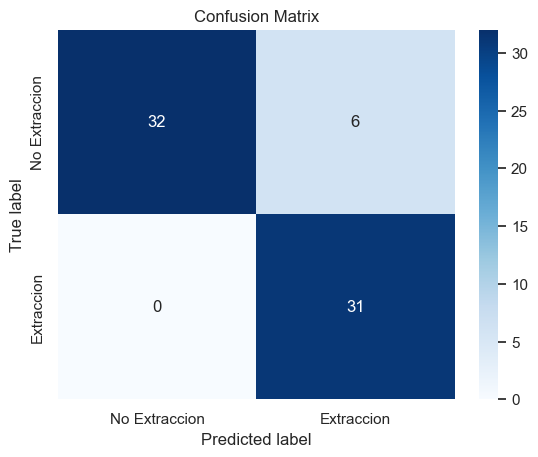

In [13]:
target_names = ['No Extraccion', 'Extraccion']
y_pred = model.predict(df_test_enc_est)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
sns.set(font_scale=1.0)

sns.heatmap(cm_df, cmap='Blues',annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [14]:
df = pd.read_csv("Base de datos FINAL_OK.csv")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
edad,342.0,17.084795,6.432264,9.0,13.0,15.0,18.0,46.0
ANB,342.0,4.480994,2.721763,-7.0,3.0,4.5,6.0,11.0
ICS_SN,342.0,107.242690,7.422494,83.0,102.0,107.0,111.0,141.0
ICS_plan_pal,342.0,64.824561,7.544098,33.0,60.0,65.0,70.0,94.0
IMPA,342.0,96.558480,9.570901,9.0,92.0,97.0,102.0,114.0
Interincisal,342.0,119.242690,10.656026,76.0,113.0,118.0,125.0,165.0
Lab_sup_Lin_e,342.0,-0.760234,2.364411,-11.0,-2.0,-1.0,1.0,6.0
Lab_inf_Lin_e,342.0,0.691520,2.578507,-9.0,-1.0,0.5,2.0,9.0
Nasolabial,342.0,97.616959,11.228475,64.0,90.0,98.0,105.0,130.0
Overjet,342.0,3.422515,2.387158,-3.0,2.0,3.0,4.0,13.0


In [15]:
df['edad'] = df['edad'] / 46
df['ANB'] = df['ANB'] / 11
df['ICS_SN'] = df['ICS_SN'] / 141
df['ICS_plan_pal'] = df['ICS_plan_pal'] / 94
df['IMPA'] = df['IMPA'] / 114
df['Interincisal'] = df['Interincisal'] / 165
df['Lab_sup_Lin_e'] = df['Lab_sup_Lin_e'] / 6
df['Lab_inf_Lin_e'] = df['Lab_inf_Lin_e'] / 9
df['Nasolabial'] = df['Nasolabial'] / 130
df['Overjet'] = df['Overjet'] / 13
df['Oberbite'] = df['Oberbite'] / 25
df['Jarabak_Sum'] = df['Jarabak_Sum'] / 931
df['Angulo_perfil'] = df['Angulo_perfil'] / 182
df['Discre_long_arco'] = df['Discre_long_arco'] / 4
df['Clase_molar'] = df['Clase_molar'] / 2
df['Perfil_labial'] = df['Perfil_labial'] / 4
df.describe().T

,count,mean,std,min,25%,50%,75%,max
edad,342.0,0.371409,0.139832,0.195652,0.282609,0.326087,0.391304,1.0
ANB,342.0,0.407363,0.247433,-0.636364,0.272727,0.409091,0.545455,1.0
ICS_SN,342.0,0.760586,0.052642,0.588652,0.723404,0.758865,0.787234,1.0
ICS_plan_pal,342.0,0.689623,0.080256,0.351064,0.638298,0.691489,0.744681,1.0
IMPA,342.0,0.847004,0.083955,0.078947,0.807018,0.850877,0.894737,1.0
Interincisal,342.0,0.722683,0.064582,0.460606,0.684848,0.715152,0.757576,1.0
Lab_sup_Lin_e,342.0,-0.126706,0.394068,-1.833333,-0.333333,-0.166667,0.166667,1.0
Lab_inf_Lin_e,342.0,0.076836,0.286501,-1.000000,-0.111111,0.055556,0.222222,1.0
Nasolabial,342.0,0.750900,0.086373,0.492308,0.692308,0.753846,0.807692,1.0
Overjet,342.0,0.263270,0.183628,-0.230769,0.153846,0.230769,0.307692,1.0


In [16]:
df.head()

,edad,genero,ANB,ICS_SN,ICS_plan_pal,IMPA,Interincisal,Lab_sup_Lin_e,Lab_inf_Lin_e,Nasolabial,Overjet,Oberbite,Jarabak_Sum,Angulo_perfil,Discre_long_arco,Clase_molar,Perfil_labial,label
0,0.673913,M,0.090909,0.751773,0.744681,0.859649,0.769697,-0.333333,0.000000,0.715385,0.307692,0.16,0.421053,0.945055,1.00,0.5,0.25,0
1,0.282609,M,0.454545,0.716312,0.744681,0.807018,0.836364,0.333333,0.000000,0.707692,0.230769,0.08,0.421053,0.890110,0.50,0.5,0.50,0
2,0.282609,M,0.272727,0.673759,0.744681,0.719298,0.860606,-0.500000,-0.222222,0.800000,0.384615,0.32,0.432868,0.895604,0.50,1.0,0.25,0
3,0.260870,F,0.681818,0.673759,0.861702,0.780702,0.854545,0.000000,0.000000,0.730769,0.269231,0.20,0.426423,0.906593,0.50,1.0,0.25,0
4,0.304348,F,0.454545,0.808511,0.638298,0.921053,0.696970,-0.166667,-0.055556,0.700000,0.230769,0.06,0.415682,0.923077,0.25,0.5,0.25,0


In [18]:
df = utils.shuffle(df,random_state=1)
x_train, x_test, y_train, y_test = train_test_split(df.drop(['label'],axis=1),df['label'],test_size=0.2,random_state=42)
x_train.shape,x_test.shape

((273, 17), (69, 17))

In [19]:
# Training
encoder = TargetEncoder(cols=['genero','Clase_molar'])
encoder.fit(x_train,y_train)

#Utiliza el mismo encoder para transformar el dataset de testing y el de testing?
df_train_enc = encoder.transform(x_train)
df_test_enc = encoder.transform(x_test)
print(df_train_enc.info())
df_train_enc.head()

<class 'pandas.core.frame.DataFrame'>
Index: 273 entries, 328 to 105
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   edad              273 non-null    float64
 1   genero            273 non-null    float64
 2   ANB               273 non-null    float64
 3   ICS_SN            273 non-null    float64
 4   ICS_plan_pal      273 non-null    float64
 5   IMPA              273 non-null    float64
 6   Interincisal      273 non-null    float64
 7   Lab_sup_Lin_e     273 non-null    float64
 8   Lab_inf_Lin_e     273 non-null    float64
 9   Nasolabial        273 non-null    float64
 10  Overjet           273 non-null    float64
 11  Oberbite          273 non-null    float64
 12  Jarabak_Sum       273 non-null    float64
 13  Angulo_perfil     273 non-null    float64
 14  Discre_long_arco  273 non-null    float64
 15  Clase_molar       273 non-null    float64
 16  Perfil_labial     273 non-null    float64
dtype

,edad,genero,ANB,ICS_SN,ICS_plan_pal,IMPA,Interincisal,Lab_sup_Lin_e,Lab_inf_Lin_e,Nasolabial,Overjet,Oberbite,Jarabak_Sum,Angulo_perfil,Discre_long_arco,Clase_molar,Perfil_labial
328,0.369565,0.431384,0.636364,0.751773,0.712766,0.885965,0.727273,-0.250000,0.166667,0.846154,0.230769,0.08,0.419979,0.895604,1.00,0.684624,0.50
99,0.347826,0.497076,0.181818,0.765957,0.659574,0.912281,0.703030,-0.250000,-0.111111,0.669231,0.076923,0.08,0.424275,0.928571,0.00,0.343558,0.25
257,0.260870,0.431384,0.272727,0.886525,0.531915,0.877193,0.636364,-0.166667,0.000000,0.692308,0.615385,0.12,0.421053,0.950549,0.50,0.684624,0.25
287,0.282609,0.431384,0.272727,0.794326,0.638298,0.929825,0.666667,0.333333,0.333333,0.723077,0.307692,0.12,0.419979,0.901099,0.75,0.343558,0.75
248,0.260870,0.431384,0.454545,0.801418,0.638298,0.894737,0.642424,0.166667,0.111111,0.715385,0.384615,0.12,0.431794,0.923077,1.00,0.684624,0.50


In [20]:
model = keras.Sequential([
    keras.layers.Dense(4, input_shape=(df_train_enc.shape[1],), activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dense(4, activation='swish', kernel_initializer='he_normal'),
    keras.layers.Dense(4, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(4, activation='swish', kernel_initializer='glorot_uniform'),
    keras.layers.Dense(4, activation='sigmoid', kernel_initializer='normal'),
    keras.layers.Dense(1, activation='hard_sigmoid', kernel_initializer='he_normal'),
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

callback = EarlyStopping(monitor='binary_accuracy', patience=50, restore_best_weights=True)

model.fit(df_train_enc, y_train, validation_data = (df_test_enc, y_test), epochs = 500, callbacks = [callback])

Epoch 1/500
9/9 [==============================] - 2s 37ms/step - loss: 0.7026 - binary_accuracy: 0.4725 - val_loss: 0.6751 - val_binary_accuracy: 0.6232
Epoch 2/500
9/9 [==============================] - 0s 12ms/step - loss: 0.7013 - binary_accuracy: 0.4725 - val_loss: 0.6764 - val_binary_accuracy: 0.6232
Epoch 3/500
9/9 [==============================] - 0s 13ms/step - loss: 0.7002 - binary_accuracy: 0.4725 - val_loss: 0.6779 - val_binary_accuracy: 0.6232
Epoch 4/500
9/9 [==============================] - 0s 12ms/step - loss: 0.6988 - binary_accuracy: 0.4725 - val_loss: 0.6794 - val_binary_accuracy: 0.6232
Epoch 5/500
9/9 [==============================] - 0s 13ms/step - loss: 0.6980 - binary_accuracy: 0.4725 - val_loss: 0.6811 - val_binary_accuracy: 0.6232
Epoch 6/500
9/9 [==============================] - 0s 12ms/step - loss: 0.6968 - binary_accuracy: 0.4725 - val_loss: 0.6822 - val_binary_accuracy: 0.6232
Epoch 7/500
9/9 [==============================] - 0s 13ms/step - loss: 0.69

Epoch 54/500
9/9 [==============================] - 0s 12ms/step - loss: 0.5130 - binary_accuracy: 0.7949 - val_loss: 0.4526 - val_binary_accuracy: 0.8406
Epoch 55/500
9/9 [==============================] - 0s 13ms/step - loss: 0.5118 - binary_accuracy: 0.7912 - val_loss: 0.4452 - val_binary_accuracy: 0.8406
Epoch 56/500
9/9 [==============================] - 0s 13ms/step - loss: 0.5087 - binary_accuracy: 0.7949 - val_loss: 0.4480 - val_binary_accuracy: 0.8406
Epoch 57/500
9/9 [==============================] - 0s 13ms/step - loss: 0.5059 - binary_accuracy: 0.7985 - val_loss: 0.4430 - val_binary_accuracy: 0.8406
Epoch 58/500
9/9 [==============================] - 0s 13ms/step - loss: 0.5040 - binary_accuracy: 0.7985 - val_loss: 0.4309 - val_binary_accuracy: 0.8551
Epoch 59/500
9/9 [==============================] - 0s 12ms/step - loss: 0.5020 - binary_accuracy: 0.7985 - val_loss: 0.4371 - val_binary_accuracy: 0.8406
Epoch 60/500
9/9 [==============================] - 0s 12ms/step - los

Epoch 107/500
9/9 [==============================] - 0s 12ms/step - loss: 0.4343 - binary_accuracy: 0.8352 - val_loss: 0.3222 - val_binary_accuracy: 0.8841
Epoch 108/500
9/9 [==============================] - 0s 12ms/step - loss: 0.4335 - binary_accuracy: 0.8352 - val_loss: 0.3253 - val_binary_accuracy: 0.8986
Epoch 109/500
9/9 [==============================] - 0s 12ms/step - loss: 0.4328 - binary_accuracy: 0.8388 - val_loss: 0.3219 - val_binary_accuracy: 0.8986
Epoch 110/500
9/9 [==============================] - 0s 12ms/step - loss: 0.4297 - binary_accuracy: 0.8388 - val_loss: 0.3143 - val_binary_accuracy: 0.8986
Epoch 111/500
9/9 [==============================] - 0s 12ms/step - loss: 0.4298 - binary_accuracy: 0.8352 - val_loss: 0.3156 - val_binary_accuracy: 0.8986
Epoch 112/500
9/9 [==============================] - 0s 13ms/step - loss: 0.4288 - binary_accuracy: 0.8425 - val_loss: 0.3227 - val_binary_accuracy: 0.9130
Epoch 113/500
9/9 [==============================] - 0s 12ms/ste

9/9 [==============================] - 0s 12ms/step - loss: 0.3884 - binary_accuracy: 0.8718 - val_loss: 0.2597 - val_binary_accuracy: 0.9275
Epoch 160/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3918 - binary_accuracy: 0.8681 - val_loss: 0.2510 - val_binary_accuracy: 0.9275
Epoch 161/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3901 - binary_accuracy: 0.8718 - val_loss: 0.2515 - val_binary_accuracy: 0.9420
Epoch 162/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3888 - binary_accuracy: 0.8718 - val_loss: 0.2546 - val_binary_accuracy: 0.9420
Epoch 163/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3888 - binary_accuracy: 0.8681 - val_loss: 0.2455 - val_binary_accuracy: 0.9275
Epoch 164/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3892 - binary_accuracy: 0.8755 - val_loss: 0.2522 - val_binary_accuracy: 0.9420
Epoch 165/500
9/9 [==============================] - 0s 12ms/step - loss: 0.38

9/9 [==============================] - 0s 12ms/step - loss: 0.3766 - binary_accuracy: 0.8755 - val_loss: 0.2400 - val_binary_accuracy: 0.9275
Epoch 212/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3753 - binary_accuracy: 0.8791 - val_loss: 0.2390 - val_binary_accuracy: 0.9275
Epoch 213/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3761 - binary_accuracy: 0.8791 - val_loss: 0.2414 - val_binary_accuracy: 0.9130
Epoch 214/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3754 - binary_accuracy: 0.8791 - val_loss: 0.2435 - val_binary_accuracy: 0.9420
Epoch 215/500
9/9 [==============================] - 0s 12ms/step - loss: 0.3751 - binary_accuracy: 0.8755 - val_loss: 0.2406 - val_binary_accuracy: 0.9130
Epoch 216/500
9/9 [==============================] - 0s 13ms/step - loss: 0.3742 - binary_accuracy: 0.8755 - val_loss: 0.2391 - val_binary_accuracy: 0.9275
Epoch 217/500
9/9 [==============================] - 0s 12ms/step - loss: 0.37

3/3 [==============================] - 0s 2ms/step
               precision    recall  f1-score   support

No Extraccion       0.92      0.92      0.92        26
   Extraccion       0.95      0.95      0.95        43

     accuracy                           0.94        69
    macro avg       0.94      0.94      0.94        69
 weighted avg       0.94      0.94      0.94        69



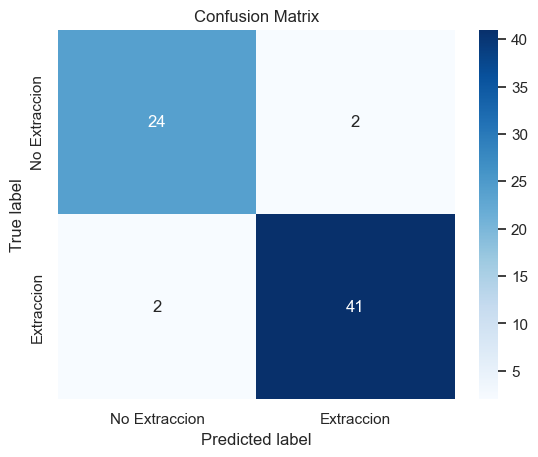

In [21]:
target_names = ['No Extraccion', 'Extraccion']
y_pred = model.predict(df_test_enc)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
sns.set(font_scale=1.0)

sns.heatmap(cm_df, cmap='Blues',annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [ ]:
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, activation_7, activation_8,
                 activation_9, activation_10,  init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, 
                init_mode_7, init_mode_8, init_mode_9, init_mode_10, optimizer):

    input_enc = keras.layers.Input(shape = (df_train_enc.shape[1],))
    enc = keras.layers.Dense(4, activation=activation_1, kernel_initializer=init_mode_1)(input_enc)
    enc = keras.Sequential([
        keras.layers.Dense(4, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(4, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(4, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(4, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(2)
    ])(enc)

    input_dec = keras.layers.Input(shape = (2,))
    dec = keras.layers.Dense(4, activation=activation_6, kernel_initializer=init_mode_6)(input_dec)
    dec  = keras.Sequential([
        keras.layers.Dense(4, activation=activation_7, kernel_initializer=init_mode_7),
        keras.layers.Dense(4, activation=activation_8, kernel_initializer=init_mode_8),
        keras.layers.Dense(4, activation=activation_9, kernel_initializer=init_mode_9),
        keras.layers.Dense(4, activation=activation_10, kernel_initializer=init_mode_10),
        keras.layers.Dense(df_train_enc.shape[1])
    ])(dec)
    
    encoder = keras.models.Model(input_enc, enc)
    decoder = keras.models.Model(input_dec, dec)

    autoencoder_input = keras.layers.Input(shape=(df_train_enc.shape[1],))
    encoded_repr = encoder(autoencoder_input)
    reconstructed = decoder(encoded_repr)

    autoencoder = keras.models.Model(autoencoder_input, reconstructed)

    autoencoder.compile(optimizer=optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanAbsoluteError(),])
    return autoencoder

# Función objetivo para Optuna
def objective(trial):
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
    activation_7 = trial.suggest_categorical('activation_7', activations_list)
    activation_8 = trial.suggest_categorical('activation_8', activations_list)
    activation_9 = trial.suggest_categorical('activation_9', activations_list)
    activation_10 = trial.suggest_categorical('activation_10', activations_list)
    
    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
    init_mode_7 = trial.suggest_categorical('init_mode_7', init_list)
    init_mode_8 = trial.suggest_categorical('init_mode_8', init_list)
    init_mode_9 = trial.suggest_categorical('init_mode_9', init_list)
    init_mode_10 = trial.suggest_categorical('init_mode_10', init_list)
    
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 
                                                        'Nadam', 'Ftrl'])
    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, activation_7, activation_8,
                 activation_9, activation_10,  init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6, 
                init_mode_7, init_mode_8, init_mode_9, init_mode_10, optimizer)
    
    history = model.fit(df_train_enc, df_train_enc, epochs=10, validation_split=0.1, verbose=0)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['mean_absolute_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print("Mejores hiperparámetros:", study.best_params)



In [ ]:
# Mejores hiperparámetros: {'activation_1': 'swish', 'activation_2': 'elu', 'activation_3': 'linear', 'activation_4': 'selu', 'activation_5': 'selu', 'activation_6': 'exponential', 'activation_7': 'exponential', 'activation_8': 'relu', 'activation_9': 'selu', 'activation_10': 'selu', 'init_mode_1': 'normal', 'init_mode_2': 'normal', 'init_mode_3': 'he_uniform', 'init_mode_4': 'he_uniform', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'uniform', 'init_mode_7': 'he_uniform', 'init_mode_8': 'he_normal', 'init_mode_9': 'zero', 'init_mode_10': 'glorot_normal', 'optimizer': 'RMSprop'}

In [ ]:
input_enc = keras.layers.Input(shape = (x_df.shape[1],))
enc = keras.layers.Dense(3, activation='elu', kernel_initializer='he_normal')(input_enc)
enc = keras.Sequential([
    keras.layers.Dense(3, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dense(3, activation='elu', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3, activation='swish', kernel_initializer='he_normal'),
    keras.layers.Dense(3, activation='swish', kernel_initializer='normal'),
    keras.layers.Dense(3)
])(enc)

In [ ]:
input_dec = keras.layers.Input(shape = (3,))
dec = keras.layers.Dense(3, activation='swish', kernel_initializer='normal')(input_dec)
dec  = keras.Sequential([
    keras.layers.Dense(3, activation='swish', kernel_initializer='he_normal'),
    keras.layers.Dense(3, activation='tanh', kernel_initializer='normal'),
    keras.layers.Dense(3, activation='elu', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dense(3)
])(dec)

In [ ]:
encoder = keras.models.Model(input_enc, enc)
decoder = keras.models.Model(input_dec, dec)

autoencoder_input = keras.layers.Input(shape=(3,))
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

autoencoder = keras.models.Model(autoencoder_input, reconstructed)

autoencoder.compile(
    optimizer='Adamax',
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=10)

In [ ]:
autoencoder.fit(x_df,  y_df, epochs=10, validation_data=(x_test, y_test),callbacks=[callback])

In [ ]:
target_names = ['No Extraccion', 'Extraccion']
y_pred = model.predict(df_test_enc)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
sns.set(font_scale=1.0)

sns.heatmap(cm_df, cmap='Blues',annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()